In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import seaborn as sns        
import matplotlib.pyplot as plt                     
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy

1. Повнозв'язані нейронні мережі
Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній № 1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network). Результати порівняйте з одержаними раніше. 

Dataset: https://www.kaggle.com/datasets/ishansingh88/europe-hotel-satisfaction-score

In [34]:
! unzip archive.zip

Archive:  archive.zip
replace Europe Hotel Booking Satisfaction Score.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [35]:
df = pd.read_csv("/content/Europe Hotel Booking Satisfaction Score.csv")
pd.set_option('display.max_columns', None)
proc_df = df.copy()
proc_df.head()

,id,Gender,Age,purpose_of_travel,Type of Travel,Type Of Booking,Hotel wifi service,Departure/Arrival convenience,Ease of Online booking,Hotel location,Food and drink,Stay comfort,Common Room entertainment,Checkin/Checkout service,Other service,Cleanliness,satisfaction
0,70172,Male,13,aviation,Personal Travel,Not defined,3,4,3,1,5,5,5,4,5,5,neutral or dissatisfied
1,5047,Male,25,tourism,Group Travel,Group bookings,3,2,3,3,1,1,1,1,4,1,neutral or dissatisfied
2,110028,Female,26,tourism,Group Travel,Group bookings,2,2,2,2,5,5,5,4,4,5,satisfied
3,24026,Female,25,tourism,Group Travel,Group bookings,2,5,5,5,2,2,2,1,4,2,neutral or dissatisfied
4,119299,Male,61,aviation,Group Travel,Group bookings,3,3,3,3,4,5,3,3,3,3,satisfied


In [36]:
proc_df.drop(['id'], axis=1, inplace=True)
proc_df['satisfaction'].replace(['neutral or dissatisfied', 'satisfied'], [0, 1], inplace=True)
categorical_columns = [
    "purpose_of_travel", "Type of Travel", "Type Of Booking", "Gender"
]

proc_df[categorical_columns] = proc_df[categorical_columns].astype(str)
dummies = pd.get_dummies(proc_df[categorical_columns], prefix=categorical_columns) 
proc_df = pd.concat([proc_df, dummies], axis=1)
proc_df.drop(categorical_columns, inplace=True, axis=1)

rating_columns = [
    'Hotel wifi service', 'Departure/Arrival  convenience',
       'Ease of Online booking', 'Hotel location', 'Food and drink',
       'Stay comfort', 'Common Room entertainment', 'Checkin/Checkout service',
       'Other service', 'Cleanliness'
]
proc_df[rating_columns] /= 5

scaler = StandardScaler()
proc_df['Age'] = scaler.fit_transform(proc_df[['Age']])

proc_df.head()

,Age,Hotel wifi service,Departure/Arrival convenience,Ease of Online booking,Hotel location,Food and drink,Stay comfort,Common Room entertainment,Checkin/Checkout service,Other service,Cleanliness,satisfaction,purpose_of_travel_academic,purpose_of_travel_aviation,purpose_of_travel_business,purpose_of_travel_personal,purpose_of_travel_tourism,Type of Travel_Group Travel,Type of Travel_Personal Travel,Type Of Booking_Group bookings,Type Of Booking_Individual/Couple,Type Of Booking_Not defined,Gender_Female,Gender_Male
0,-1.745279,0.6,0.8,0.6,0.2,1.0,1.0,1.0,0.8,1.0,1.0,0,0,1,0,0,0,0,1,0,0,1,0,1
1,-0.951360,0.6,0.4,0.6,0.6,0.2,0.2,0.2,0.2,0.8,0.2,0,0,0,0,0,1,1,0,1,0,0,0,1
2,-0.885200,0.4,0.4,0.4,0.4,1.0,1.0,1.0,0.8,0.8,1.0,1,0,0,0,0,1,1,0,1,0,0,1,0
3,-0.951360,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.2,0.8,0.4,0,0,0,0,0,1,1,0,1,0,0,1,0
4,1.430397,0.6,0.6,0.6,0.6,0.8,1.0,0.6,0.6,0.6,0.6,1,0,1,0,0,0,1,0,1,0,0,0,1


In [37]:
proc_df['satisfaction'].value_counts()

0    58879
1    45025
Name: satisfaction, dtype: int64

In [74]:
y = proc_df["satisfaction"]
X = proc_df.drop("satisfaction", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_tensor = torch.tensor(X_train.values).to(torch.float32)
X_test_tensor = torch.tensor(X_test.values).to(torch.float32)
y_train_tensor = torch.tensor(y_train.values).view([-1, 1]).to(torch.float32)
y_test_tensor = torch.tensor(y_test.values).view([-1, 1]).to(torch.float32)

print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([72732, 23]) torch.Size([31172, 23]) torch.Size([72732, 1]) torch.Size([31172, 1])


In [78]:
class MLP_M(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(23, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x


model = MLP_M()
print(model)

Vadick(
  (fc1): Linear(in_features=23, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=1, bias=True)
)


In [79]:
learning_rate = 0.001
num_epochs = 500

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
binary_accuracy = BinaryAccuracy()

losses = []
accuracies = []
for epoch in tqdm(range(num_epochs)):
    pred_y = model(X_train_tensor)

    loss = loss_function(pred_y, y_train_tensor)
    accuracy = binary_accuracy(pred_y, y_train_tensor)
    losses.append(loss.item())
    accuracies.append(accuracy.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

100%|██████████| 500/500 [00:37<00:00, 13.41it/s]


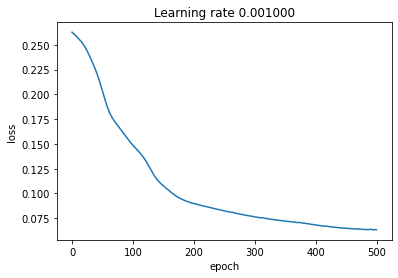

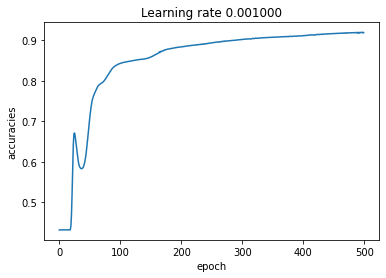

0.9188053607940674


In [80]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

plt.plot(accuracies)
plt.ylabel('accuracies')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

pred_y = model(X_test_tensor)
print(binary_accuracy(pred_y, y_test_tensor).item())